In [3]:
import torch
import time
from transformers import *
import numpy as np
import os, json

from collections import defaultdict
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, OPTICS
from sklearn import cluster, mixture
# t-sne
from sklearn import manifold
import sklearn
from sklearn.metrics import confusion_matrix
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm


colors = ['#F15BB5', '#FEE440', '#00BBF9', '#02C39A', '#FDC500', '#00509D', 'red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'black']
markers = ['o', '*', '^']
base_path_new = '../../data'

file_paths_new = {
                'NQ': os.path.join(base_path_new, 'nq/train.jsonl'),
                'RACE': os.path.join(base_path_new, 'RACE/train.jsonl'),
                # 'SQuAD': os.path.join(base_path_new, 'squad/train.jsonl'),
                'SciQ':  os.path.join(base_path_new, 'SciQ/train.jsonl'),
            }
models_to_use = ['bert-large-uncased']
examples_numbers = {
    'NQ': 3000,
    'RACE': 3000,
    # 'SQuAD': 3000,
    'SciQ': 3000,
}



2021-09-17 18:58:09.400716: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [38]:
import random

In [39]:
random.seed(42)
np.random.seed(42)

In [4]:
model = AutoModel.from_pretrained(models_to_use[0]).eval().to(1)
tokenizer = AutoTokenizer.from_pretrained(models_to_use[0])


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:

sciq_ds = [' '.join(json.loads(_)['text']).lower() for _ in open(file_paths_new['SciQ'])]
race_ds = [' '.join(json.loads(_)['text']).lower() for _ in open(file_paths_new['RACE'])]
nq_ds = [' '.join(json.loads(_)['text']).lower() for _ in open(file_paths_new['NQ'])]


In [6]:
num_used_for_clustering = 3000
pca_dims = 30
corpus = {
    'NQ': nq_ds,
    'RACE': race_ds,
    'SciQ': sciq_ds,
}

In [7]:
features = {_:[] for _ in corpus.keys()}
with torch.no_grad():
    for domain, ds in corpus.items():
        items = list(set(ds))[:num_used_for_clustering]
        avg_pool = []
        cls_features = []
        avg_all_pool = []
        for d in tqdm(items):
            out = model(**tokenizer(d, max_length=512, truncation=True, return_tensors='pt').to(1), output_hidden_states=True)
            average_pool = torch.mean(out[0], dim=1).detach().cpu()
            cls_pooler = out[1].detach().cpu()
            average_pool_all_layers = torch.mean( torch.cat([torch.mean(_, dim=1).detach().cpu() for _ in out[2]]), dim=0).unsqueeze(dim=0)
        
            avg_pool.append(average_pool)
            cls_features.append(cls_pooler)
            avg_all_pool.append(average_pool_all_layers)
        features[domain].append( torch.cat(avg_pool, dim=0))
        features[domain].append( torch.cat(cls_features, dim=0))
        features[domain].append( torch.cat(avg_all_pool, dim=0))
        

100%|██████████| 3000/3000 [01:27<00:00, 34.38it/s]


In [8]:
states_avg = torch.cat([features['NQ'][0], features['RACE'][0], features['SciQ'][0]], dim=0)
states_cls = torch.cat([features['NQ'][1], features['RACE'][1], features['SciQ'][1]], dim=0)
states_all = torch.cat([features['NQ'][2], features['RACE'][2], features['SciQ'][2]], dim=0)

In [9]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)

In [10]:
tsne_cls_data = tsne.fit_transform(states_cls)

In [11]:
tsne_avg_data = tsne.fit_transform(states_avg)

In [12]:
tsne_all_data = tsne.fit_transform(states_all)

In [13]:
true_labels = ['NQ']*num_used_for_clustering + ['RACE']*num_used_for_clustering + ['SciQ']*num_used_for_clustering

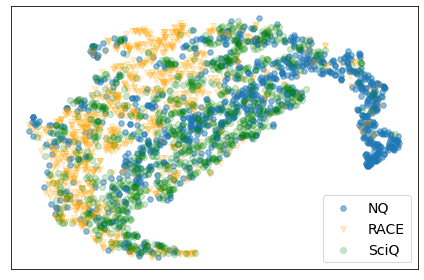

In [14]:
colors = ['#F15BB5', '#FEE440', '#00BBF9', '#02C39A', '#FDC500', '#00509D', 'red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'black']
tsne_data = tsne_cls_data
num = 1000
domain_index = {'NQ':0, 'RACE':3000, 'SciQ':6000}
plt.scatter(tsne_data[domain_index['NQ']:domain_index['NQ']+num, 0], tsne_data[domain_index['NQ']:domain_index['NQ']+num, 1], marker='H', label='NQ', alpha=0.5)
plt.scatter(tsne_data[domain_index['RACE']:domain_index['RACE']+num, 0], tsne_data[domain_index['RACE']:domain_index['RACE']+num, 1], marker='v', label='RACE', alpha=0.2, color='orange')
# plt.scatter(tsne_data[domain_index['SQuAD']:domain_index['SQuAD']+num, 0], tsne_data[domain_index['SQuAD']:domain_index['SQuAD']+num, 1], label='SQuAD', alpha=0.1)
plt.scatter(tsne_data[domain_index['SciQ']:domain_index['SciQ']+num, 0], tsne_data[domain_index['SciQ']:domain_index['SciQ']+num, 1], label='SciQ', alpha=0.2, color='green')
plt.legend(loc='lower right', prop=dict(size=14))
plt.xticks(())
plt.yticks(())
plt.tight_layout()
# plt.savefig("domains_tsne.pdf", dpi=600, bbox_inches='tight')

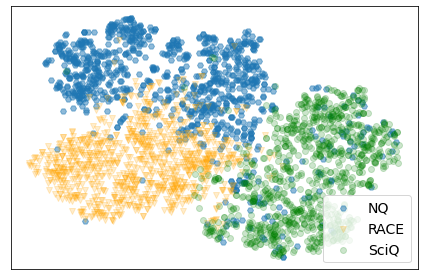

In [15]:
colors = ['#F15BB5', '#FEE440', '#00BBF9', '#02C39A', '#FDC500', '#00509D', 'red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'black']
tsne_data = tsne_avg_data
num = 1000
domain_index = {'NQ':0, 'RACE':3000, 'SciQ':6000}
plt.scatter(tsne_data[domain_index['NQ']:domain_index['NQ']+num, 0], tsne_data[domain_index['NQ']:domain_index['NQ']+num, 1], marker='H', label='NQ', alpha=0.5)
plt.scatter(tsne_data[domain_index['RACE']:domain_index['RACE']+num, 0], tsne_data[domain_index['RACE']:domain_index['RACE']+num, 1], marker='v', label='RACE', alpha=0.2, color='orange')
# plt.scatter(tsne_data[domain_index['SQuAD']:domain_index['SQuAD']+num, 0], tsne_data[domain_index['SQuAD']:domain_index['SQuAD']+num, 1], label='SQuAD', alpha=0.1)
plt.scatter(tsne_data[domain_index['SciQ']:domain_index['SciQ']+num, 0], tsne_data[domain_index['SciQ']:domain_index['SciQ']+num, 1], label='SciQ', alpha=0.2, color='green')
plt.legend(loc='lower right', prop=dict(size=14))
plt.xticks(())
plt.yticks(())
plt.tight_layout()
# plt.savefig("domains_tsne.pdf", dpi=600, bbox_inches='tight')

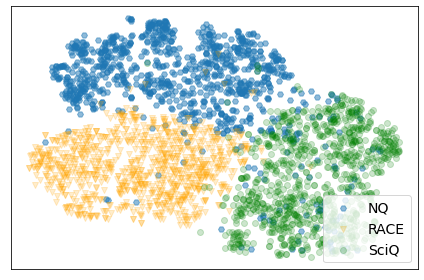

In [16]:
colors = ['#F15BB5', '#FEE440', '#00BBF9', '#02C39A', '#FDC500', '#00509D', 'red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'black']
tsne_data = tsne_all_data
num = 1000
domain_index = {'NQ':0, 'RACE':3000, 'SciQ':6000}
plt.scatter(tsne_data[domain_index['NQ']:domain_index['NQ']+num, 0], tsne_data[domain_index['NQ']:domain_index['NQ']+num, 1], marker='H', label='NQ', alpha=0.5)
plt.scatter(tsne_data[domain_index['RACE']:domain_index['RACE']+num, 0], tsne_data[domain_index['RACE']:domain_index['RACE']+num, 1], marker='v', label='RACE', alpha=0.2, color='orange')
# plt.scatter(tsne_data[domain_index['SQuAD']:domain_index['SQuAD']+num, 0], tsne_data[domain_index['SQuAD']:domain_index['SQuAD']+num, 1], label='SQuAD', alpha=0.1)
plt.scatter(tsne_data[domain_index['SciQ']:domain_index['SciQ']+num, 0], tsne_data[domain_index['SciQ']:domain_index['SciQ']+num, 1], label='SciQ', alpha=0.2, color='green')
plt.legend(loc='lower right', prop=dict(size=14))
plt.xticks(())
plt.yticks(())
plt.tight_layout()
# plt.savefig("domains_tsne.pdf", dpi=600, bbox_inches='tight')

In [17]:
def scatter_unsupervised_results(data, labels_):
    labels = set(labels_)
    print(len(labels))
    colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, 10)] #len(labels))]
    # colors = [plt.cm.Spectral(each)
    #         for each in np.linspace(0, 1, len(labels))]
    # colors = ['green', 'b', 'orange']
    for _j, l in enumerate(list(labels)[:]):
        items = np.concatenate( [np.expand_dims(data[i, :], axis=0) for i in range(data.shape[0]) if labels_[i] == l] )
        print(items.shape)
        plt.scatter(items[:, 0], items[:, 1], alpha=0.3, color=colors[_j], label=str(l))
    if len(labels) < 5:
        plt.legend()

In [26]:
print(set(true_labels))

{'SciQ', 'NQ', 'RACE'}


In [25]:
true_types = list(set(true_labels))
type_idx = {_:idx  for idx, _ in enumerate(true_types)}
print(true_types)
print(type_idx)

['SciQ', 'NQ', 'RACE']
{'SciQ': 0, 'NQ': 1, 'RACE': 2}


In [27]:
def calc_precision_and_confusion(true_labels, labels_):
    clusters = list(set(labels_))
    cluster_idx = {_:idx  for idx, _ in enumerate(clusters)}
    true_types = list(set(true_labels))
    type_idx = {_:idx  for idx, _ in enumerate(true_types)}
    cluster_items = {_:[] for _ in clusters}
    for idx, lb in enumerate(labels_):
        cluster_items[lb].append(idx)

    # judge label type of the cluster
    print(len(clusters))
    cluster_true_label_map = {}
    for cluster, idxs in cluster_items.items():
        label_cnt = {_:0 for _ in true_types}
        for idx in idxs:
            label_cnt[true_labels[idx]] += 1
        label_sort = sorted(label_cnt.items(), key=lambda d: d[1], reverse=True)
        print(label_sort)
        cluster_true_label_map[cluster] = label_sort[0][0]
    print(cluster_true_label_map)
    
    confu_mat = np.zeros((len(clusters), len(true_types)), dtype=np.int32)
    for idx, cluster in enumerate(labels_):
        confu_mat[cluster_idx[cluster]][type_idx[true_labels[idx]]] += 1
    print(confu_mat)

    confu_mat = np.zeros((len(true_types), len(true_types)), dtype=np.int32)
    ypred = []
    for idx, cluster in enumerate(labels_):
        confu_mat[ type_idx[cluster_true_label_map[cluster]]][type_idx[true_labels[idx]]] += 1
        ypred.append(cluster_true_label_map[cluster])
    print(confu_mat)

    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, ypred)
    # Only use the labels that appear in the data
    uniq = unique_labels(true_labels, ypred)

    normalize = False
    cmap = plt.cm.Blues
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    classes = list(set(true_labels))
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # Show all ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # And label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    # fig.savefig("main_confusion.pdf", bbox_inches='tight')
    plt.close()
    return ax    

In [19]:
ttd = PCA(n_components=pca_dims, random_state=0).fit_transform(states_all)

3
(3353, 2)
(2440, 2)
(3207, 2)


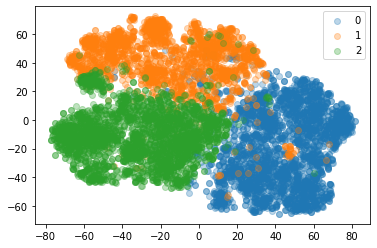

In [45]:
bbd = cluster.Birch(threshold=0.01, n_clusters=3).fit(ttd)
scatter_unsupervised_results(tsne_all_data, bbd.labels_)

3
[('SciQ', 2929), ('NQ', 403), ('RACE', 21)]
[('NQ', 2359), ('SciQ', 49), ('RACE', 32)]
[('RACE', 2947), ('NQ', 238), ('SciQ', 22)]
{0: 'SciQ', 1: 'NQ', 2: 'RACE'}
[[2929  403   21]
 [  49 2359   32]
 [  22  238 2947]]
[[2929  403   21]
 [  49 2359   32]
 [  22  238 2947]]
Confusion matrix, without normalization
[[2359  238  403]
 [  32 2947   21]
 [  49   22 2929]]


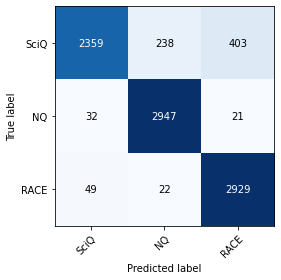

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

In [46]:
calc_precision_and_confusion(true_labels, bbd.labels_)

5
(1661, 2)
(1814, 2)
(3001, 2)
(1044, 2)
(1480, 2)
5
[('NQ', 1531), ('RACE', 103), ('SciQ', 27)]
[('SciQ', 1622), ('NQ', 180), ('RACE', 12)]
[('RACE', 2874), ('NQ', 102), ('SciQ', 25)]
[('NQ', 1033), ('RACE', 6), ('SciQ', 5)]
[('SciQ', 1321), ('NQ', 154), ('RACE', 5)]
{0: 'NQ', 1: 'SciQ', 2: 'RACE', 3: 'NQ', 4: 'SciQ'}
[[  27 1531  103]
 [1622  180   12]
 [  25  102 2874]
 [   5 1033    6]
 [1321  154    5]]
[[2943  334   17]
 [  32 2564  109]
 [  25  102 2874]]
Confusion matrix, without normalization
[[2564  102  334]
 [ 109 2874   17]
 [  32   25 2943]]


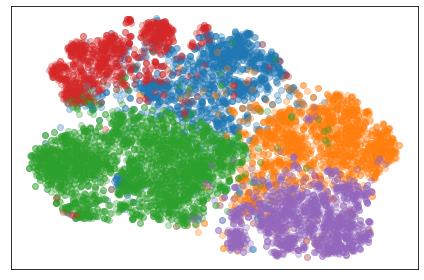

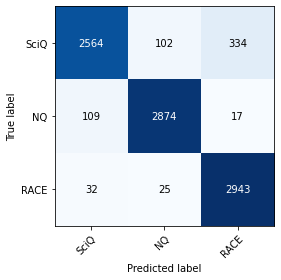

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

In [29]:

bd = GaussianMixture(n_components=5, covariance_type='spherical', max_iter=150, random_state=0).fit(ttd)
scatter_unsupervised_results(tsne_all_data, bd.predict(ttd))
plt.xticks(())
plt.yticks(())
plt.tight_layout()
# plt.savefig("domains_gmm.pdf", dpi=600, bbox_inches='tight')
calc_precision_and_confusion(true_labels, bd.predict(ttd))

3
(2633, 2)
(3361, 2)
(3006, 2)
3
[('NQ', 2507), ('RACE', 103), ('SciQ', 23)]
[('SciQ', 2949), ('NQ', 388), ('RACE', 24)]
[('RACE', 2873), ('NQ', 105), ('SciQ', 28)]
{0: 'NQ', 1: 'SciQ', 2: 'RACE'}
[[  23 2507  103]
 [2949  388   24]
 [  28  105 2873]]
[[2949  388   24]
 [  23 2507  103]
 [  28  105 2873]]
Confusion matrix, without normalization
[[2507  105  388]
 [ 103 2873   24]
 [  23   28 2949]]


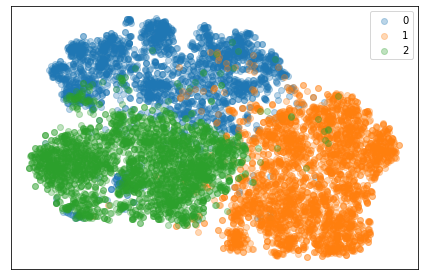

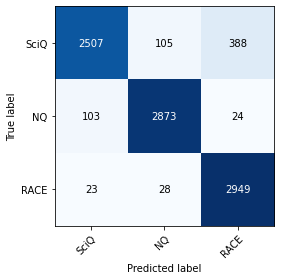

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

In [35]:

bd = GaussianMixture(n_components=3, covariance_type='spherical', max_iter=150, random_state=0).fit(ttd)
scatter_unsupervised_results(tsne_all_data, bd.predict(ttd))
plt.xticks(())
plt.yticks(())
plt.tight_layout()
# plt.savefig("domains_gmm.pdf", dpi=600, bbox_inches='tight')
calc_precision_and_confusion(true_labels, bd.predict(ttd))

4
(71, 2)
(74, 2)
(1006, 2)
(7849, 2)
4
[('NQ', 71), ('SciQ', 0), ('RACE', 0)]
[('NQ', 74), ('SciQ', 0), ('RACE', 0)]
[('RACE', 1006), ('SciQ', 0), ('NQ', 0)]
[('SciQ', 3000), ('NQ', 2855), ('RACE', 1994)]
{0: 'NQ', 1: 'NQ', 2: 'RACE', -1: 'SciQ'}
[[   0   71    0]
 [   0   74    0]
 [   0    0 1006]
 [3000 2855 1994]]
[[3000 2855 1994]
 [   0  145    0]
 [   0    0 1006]]
Confusion matrix, without normalization
[[ 145    0 2855]
 [   0 1006 1994]
 [   0    0 3000]]


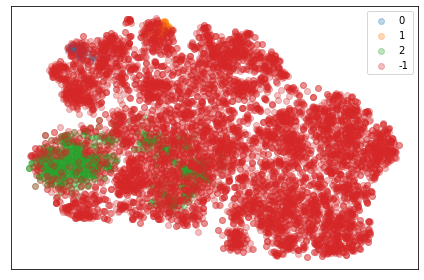

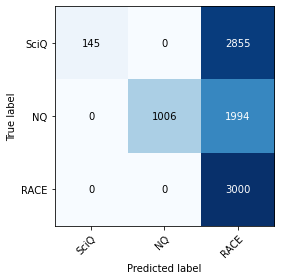

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

In [109]:
dbn = DBSCAN(eps=1, min_samples=20).fit(ttd)
# bd = GaussianMixture(n_components=3, covariance_type='spherical', max_iter=150, random_state=0).fit(new_ttd)
scatter_unsupervised_results(tsne_all_data, dbn.labels_)
plt.xticks(())
plt.yticks(())
plt.tight_layout()
# plt.savefig("domains_gmm.pdf", dpi=600, bbox_inches='tight')
calc_precision_and_confusion(true_labels, dbn.labels_)

In [61]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

In [ ]:
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(30)
normalizer = Normalizer(copy=False)



In [67]:
minikm = MiniBatchKMeans(n_clusters=3, init='k-means++', n_init=1,
                        init_size=1000, batch_size=1000, verbose=0)
km = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1,
            verbose=0, metric)

In [73]:
km = minikm.fit(tsne_all_data)

In [74]:
km.cluster_centers_.shape

(3, 2)

3
(2611, 2)
(3485, 2)
(2904, 2)
3
[('NQ', 2455), ('RACE', 133), ('SciQ', 23)]
[('SciQ', 2962), ('NQ', 324), ('RACE', 199)]
[('RACE', 2668), ('NQ', 221), ('SciQ', 15)]
{0: 'NQ', 1: 'SciQ', 2: 'RACE'}
[[  23 2455  133]
 [2962  324  199]
 [  15  221 2668]]
[[2962  324  199]
 [  23 2455  133]
 [  15  221 2668]]
Confusion matrix, without normalization
[[2455  221  324]
 [ 133 2668  199]
 [  23   15 2962]]


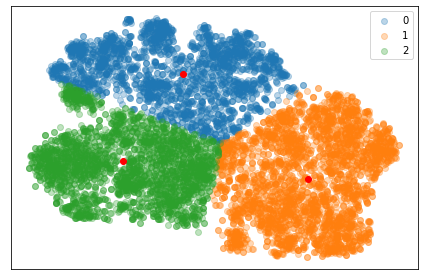

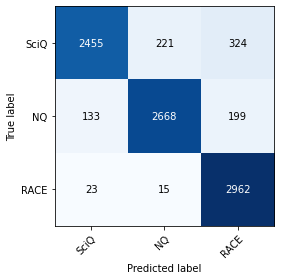

In [80]:
scatter_unsupervised_results(tsne_all_data, km.labels_)
plt.xticks(())
plt.yticks(())
plt.tight_layout()

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='r')
calc_precision_and_confusion(true_labels, km.labels_)
plt.show()

In [40]:
# add new lines 
newfeatures = {_:[] for _ in corpus.keys()}
with torch.no_grad():
    for domain, ds in corpus.items():
        x = list(set(ds))[num_used_for_clustering:]
        random.shuffle(x)
        items = x[:num_used_for_clustering] #list(set(ds))[num_used_for_clustering:num_used_for_clustering*2]
        avg_pool = []
        cls_features = []
        avg_all_pool = []
        for d in tqdm(items):
            out = model(**tokenizer(d, max_length=512, truncation=True, return_tensors='pt').to(1), output_hidden_states=True)
            average_pool = torch.mean(out[0], dim=1).detach().cpu()
            cls_pooler = out[1].detach().cpu()
            average_pool_all_layers = torch.mean( torch.cat([torch.mean(_, dim=1).detach().cpu() for _ in out[2]]), dim=0).unsqueeze(dim=0)
        
            avg_pool.append(average_pool)
            cls_features.append(cls_pooler)
            avg_all_pool.append(average_pool_all_layers)
        newfeatures[domain].append( torch.cat(avg_pool, dim=0))
        newfeatures[domain].append( torch.cat(cls_features, dim=0))
        newfeatures[domain].append( torch.cat(avg_all_pool, dim=0))

100%|██████████| 3000/3000 [01:28<00:00, 33.76it/s]


In [41]:
new_states_avg = torch.cat([newfeatures['NQ'][0], newfeatures['RACE'][0], newfeatures['SciQ'][0]], dim=0)
new_states_cls = torch.cat([newfeatures['NQ'][1], newfeatures['RACE'][1], newfeatures['SciQ'][1]], dim=0)
new_states_all = torch.cat([newfeatures['NQ'][2], newfeatures['RACE'][2], newfeatures['SciQ'][2]], dim=0)

In [42]:
new_tsne_all_data = tsne.fit_transform(new_states_all)

In [43]:
new_ttd = PCA(n_components=pca_dims, random_state=0).fit_transform(new_states_all)

3
(2645, 2)
(3351, 2)
(3004, 2)
3
[('NQ', 2542), ('RACE', 84), ('SciQ', 19)]
[('SciQ', 2961), ('NQ', 361), ('RACE', 29)]
[('RACE', 2887), ('NQ', 97), ('SciQ', 20)]
{0: 'NQ', 1: 'SciQ', 2: 'RACE'}
[[  19 2542   84]
 [2961  361   29]
 [  20   97 2887]]
[[2961  361   29]
 [  19 2542   84]
 [  20   97 2887]]
Confusion matrix, without normalization
[[2542   97  361]
 [  84 2887   29]
 [  19   20 2961]]


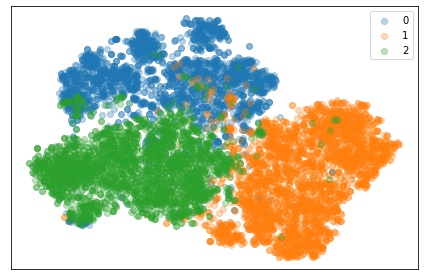

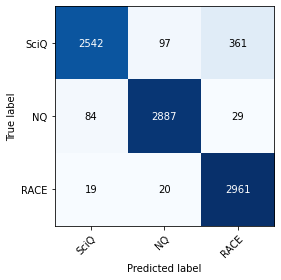

<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

In [44]:

# bd = GaussianMixture(n_components=3, covariance_type='spherical', max_iter=150, random_state=0).fit(new_ttd)
scatter_unsupervised_results(new_tsne_all_data, bd.predict(new_ttd))
plt.xticks(())
plt.yticks(())
plt.tight_layout()
# plt.savefig("domains_gmm.pdf", dpi=600, bbox_inches='tight')
calc_precision_and_confusion(true_labels, bd.predict(new_ttd))

In [1]:
p = PCA(n_components=pca_dims, random_state=0)

NameError: name 'PCA' is not defined